In [60]:
import numpy as np
import pandas as pd

import cv2
from pathlib import Path

import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.feature import local_binary_pattern

import os, glob, random



In [61]:
def get_rgb(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_hsv(path):
    img = cv2.imread(path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return hsv

def get_green_coverage(img):
    green_mask = (img[:, :, 1] > img[:, :, 0]) & (img[:, :, 1] > img[:, :, 2])
    return green_mask.sum() / green_mask.size

def get_gray(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def get_sobel(gray_, ksize = 3):
    sobelx  = cv2.Sobel(gray_, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely  = cv2.Sobel(gray_, cv2.CV_64F, 0, 1, ksize=ksize)
    return np.sqrt(sobelx**2 + sobely**2)

def get_canny(gray_, low_threshold = 100, high_threshold = 200): 
    return cv2.Canny(gray_, low_threshold, high_threshold) 
    
def get_binary(gray, threshold = 127):
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    return binary 
 
def get_lbp(gray_, p = 8, r = 3, method = "uniform"):
    return local_binary_pattern(gray_, P=p, R=r, method=method)

def get_contours(binary):
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [62]:
def update_features(path_):

    all_features = {}

    all_features.update(get_rgb_hsv_features(path_))
    all_features.update(get_texture_features(path_))

    return all_features


def get_rgb_hsv_features(path_):
    features = {}

    rgb_img = get_rgb(path_)
    hsv_img = get_hsv(path_)

    for i , channel in enumerate(['r', 'g', 'b']):
        features[f'{channel}_mean']     = rgb_img[:, :, i].mean()
        features[f'{channel}_median']   = np.median(rgb_img[:, :, i])
        features[f'{channel}_std']      = rgb_img[:, :, i].std()
    
    features['green_coverage'] = get_green_coverage(rgb_img); del rgb_img

    for i , channel in enumerate(['hue', 'sat', 'val']):
        features[f'{channel}_mean']     = hsv_img[:, :, i].mean()
        features[f'{channel}_std']      = hsv_img[:, :, i].std()
    
    del hsv_img    
    return features     

def get_texture_features(path_):
    features = {}

    gray_img    = get_gray(path_)
    sobel_img   = get_sobel(gray_img)
    canny_img   = get_canny(gray_img)
    binary_img  = get_binary(gray_img)
    lbp_img     = get_lbp(gray_img)

    features['sobel_mean']  = sobel_img.mean()
    features['sobel_std']   = sobel_img.std(); del sobel_img

    features['canny_mean']  = canny_img.mean()
    features['canny_std']   = canny_img.std(); del canny_img

    features['binary_mean'] = binary_img.mean()
    features['binary_std']  = binary_img.std(); del binary_img
 
    features['lbp_mean']    = lbp_img.mean()
    features['lbp_std']     = lbp_img.std(); del lbp_img

    return features


In [63]:
project_path = "/Users/k.choi/Documents/github/csiro_git"
data_path   = os.path.join(project_path, "data")
img_path    = os.path.join(data_path, "train")
img_list    = glob.glob(os.path.join(img_path, "*.jpg"))
train_df    = pd.read_csv(os.path.join(data_path, "train.csv"))
train_df['image_id'] = train_df['image_path'].apply(lambda x: Path(x).stem)

print('project_path : ', project_path)
print('data_path : ', data_path)
print('img_path : ', img_path)
print('total number of images : ', len(img_list))
print('train_df : ', train_df.info())

project_path :  /Users/k.choi/Documents/github/csiro_git
data_path :  /Users/k.choi/Documents/github/csiro_git/data
img_path :  /Users/k.choi/Documents/github/csiro_git/data/train
total number of images :  357
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_id      1785 non-null   object 
 1   image_path     1785 non-null   object 
 2   Sampling_Date  1785 non-null   object 
 3   State          1785 non-null   object 
 4   Species        1785 non-null   object 
 5   Pre_GSHH_NDVI  1785 non-null   float64
 6   Height_Ave_cm  1785 non-null   float64
 7   target_name    1785 non-null   object 
 8   target         1785 non-null   float64
 9   image_id       1785 non-null   object 
dtypes: float64(3), object(7)
memory usage: 139.6+ KB
train_df :  None


/Users/k.choi/Documents/github/csiro_git/data/train/ID1413758094.jpg


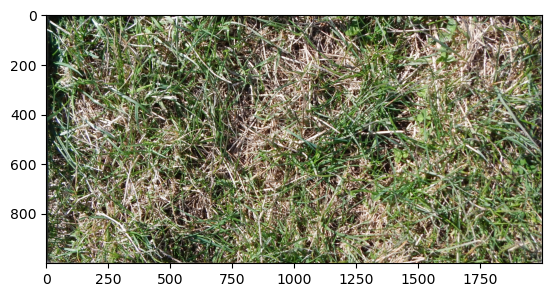

/Users/k.choi/Documents/github/csiro_git/data/train/ID121331988.jpg


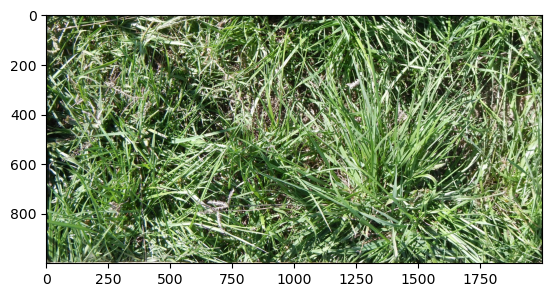

/Users/k.choi/Documents/github/csiro_git/data/train/ID661372352.jpg


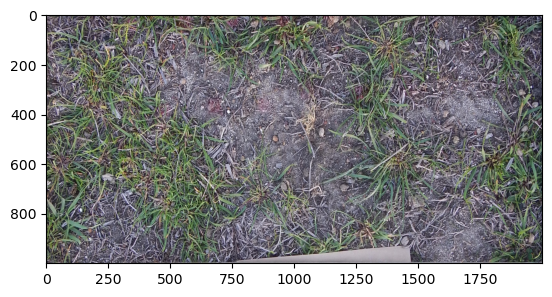

/Users/k.choi/Documents/github/csiro_git/data/train/ID1590632667.jpg


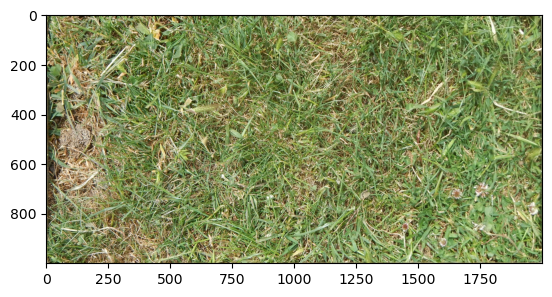

/Users/k.choi/Documents/github/csiro_git/data/train/ID1645161155.jpg


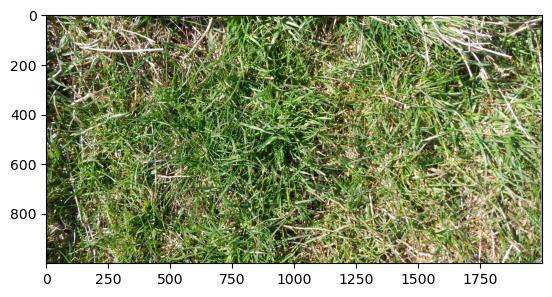

/Users/k.choi/Documents/github/csiro_git/data/train/ID633775166.jpg


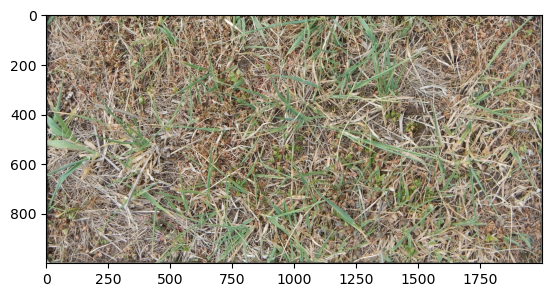

/Users/k.choi/Documents/github/csiro_git/data/train/ID1451025862.jpg


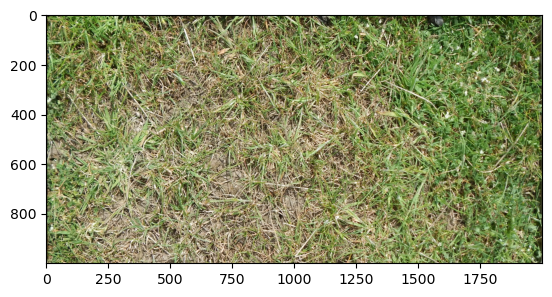

In [64]:
selected_img_path = random.sample(img_list, 7)

for img_path in selected_img_path:
    print(img_path)
    rgb_img = get_rgb(img_path)
    plt.imshow(rgb_img)
    plt.show()

In [65]:
features_list = []

for img_path in tqdm(selected_img_path):

    try:
        features = update_features(img_path)
    
        features['image_id'] = Path(img_path).stem

        features_list.append(features)

    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        continue

features_df = pd.DataFrame(features_list)
cols = ['image_id'] + [ col for col in features_df.columns if col != 'image_id' ]
features_df = features_df[cols]




100%|██████████| 7/7 [00:01<00:00,  3.69it/s]


In [66]:
metadata_df = train_df.groupby('image_id').first()[['Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'target_name', 'target']].reset_index()

complete_df = pd.merge(features_df, metadata_df, on='image_id', how='left')

complete_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_id        7 non-null      object 
 1   r_mean          7 non-null      float64
 2   r_median        7 non-null      float64
 3   r_std           7 non-null      float64
 4   g_mean          7 non-null      float64
 5   g_median        7 non-null      float64
 6   g_std           7 non-null      float64
 7   b_mean          7 non-null      float64
 8   b_median        7 non-null      float64
 9   b_std           7 non-null      float64
 10  green_coverage  7 non-null      float64
 11  hue_mean        7 non-null      float64
 12  hue_std         7 non-null      float64
 13  sat_mean        7 non-null      float64
 14  sat_std         7 non-null      float64
 15  val_mean        7 non-null      float64
 16  val_std         7 non-null      float64
 17  sobel_mean      7 non-null      float64

In [67]:
complete_df

,image_id,r_mean,r_median,r_std,g_mean,g_median,g_std,b_mean,b_median,b_std,...,binary_std,lbp_mean,lbp_std,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1413758094,116.695409,107.0,65.038581,118.380554,110.0,64.312767,88.664807,74.0,65.112970,...,124.658898,5.453465,3.197130,2015/9/4,Tas,Ryegrass_Clover,0.54,5.0000,Dry_Clover_g,0.8746
1,ID121331988,106.165403,83.0,73.445460,129.447544,113.0,72.820185,85.045917,60.0,71.607372,...,124.994240,5.600619,3.258022,2015/5/7,NSW,Fescue,0.75,8.0000,Dry_Clover_g,0.0000
2,ID661372352,105.110086,102.0,46.996099,105.605911,103.0,46.936714,106.215757,103.0,47.173429,...,119.379027,5.654425,3.330857,2015/7/8,WA,Clover,0.26,1.0000,Dry_Clover_g,0.0000
3,ID1590632667,128.147444,127.0,48.547091,138.476611,141.0,47.663631,85.097442,82.0,47.486931,...,127.400646,5.580063,3.263806,2015/11/9,Tas,Ryegrass_Clover,0.70,3.8333,Dry_Clover_g,3.1807
4,ID1645161155,115.824782,107.0,65.691223,128.450288,121.0,64.313365,77.586671,62.0,64.894638,...,126.056787,5.474319,3.202098,2015/9/4,Tas,Ryegrass_Clover,0.70,4.5000,Dry_Clover_g,0.0000
5,ID633775166,143.845281,147.0,51.997062,134.466586,141.0,52.813320,112.743371,115.0,52.380574,...,125.795940,5.701901,3.333773,2015/10/13,Vic,Phalaris_BarleyGrass_SilverGrass_SpearGrass_Cl...,0.36,4.3000,Dry_Clover_g,2.8120
6,ID1451025862,130.553809,129.0,55.275000,135.183688,138.0,53.548323,87.285387,82.0,53.657467,...,127.485288,5.641707,3.310284,2015/11/10,Tas,Ryegrass_Clover,0.53,2.8333,Dry_Clover_g,5.3000


In [68]:
complete_df.duplicated().sum()

np.int64(0)

In [69]:
complete_df['target_name']

0    Dry_Clover_g
1    Dry_Clover_g
2    Dry_Clover_g
3    Dry_Clover_g
4    Dry_Clover_g
5    Dry_Clover_g
6    Dry_Clover_g
Name: target_name, dtype: object